In [42]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import signal
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime

In [2]:
#path = '../fma_small/000/*.mp3'
num_dirs = 2
dirs = glob('../fma_small/*')
dirs = dirs[:num_dirs]
dirs = [str(dirs[i]) + str('/*.mp3') for i in range(len(dirs))]
dirs = [glob(dirs[i]) for i in range(len(dirs))]
path = []
for i in range(len(dirs)):
    path += dirs[i]

0:00:00.635129


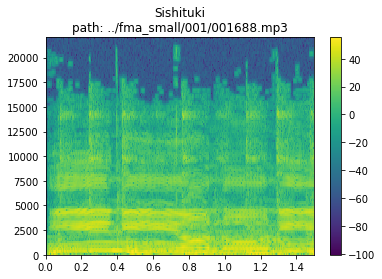

spec shape is: (129, 515)


In [50]:
start = datetime.datetime.now()
music = AudioSegment.from_file(path[0])
sample = np.array(music.get_array_of_samples())
sample = [sample[i] for i in range(0,3*44100,2)] #get left channel only
Fs = music[0].frame_rate # get frame, usually 44100

tag = mediainfo(path[0]) # get name of the song
spec, freqs, bins, im = plt.specgram(sample, Fs=Fs) # create spectrogram
end = datetime.datetime.now()
print(end-start)
plt.colorbar()
plt.title(str(tag['TAG']['title'])+'\npath: '+str(path[0]))
plt.show()
print('spec shape is: '+str(spec.shape))
Audio(data=sample, rate=Fs)

In [53]:
start = datetime.datetime.now()
music = AudioSegment.from_file(path[0])
sample = np.array(music.get_array_of_samples())
sample = [sample[i] for i in range(0,3*44100,2)] #get left channel only
#sample[1] = [sample[1][i] for i in range(0,3*44100,2)] #get left channel only
sample = np.asarray(sample)
sample = sample.astype(np.float32)
stfts = tf.signal.stft(sample, frame_length=1024, frame_step=512, fft_length=1024)
end = datetime.datetime.now()
print(end-start)
with sess.as_default():
    print(stfts.eval())

0:00:00.481145
[[ 5.0563438e+04+0.00000000e+00j  8.7976859e+04-8.62216875e+04j
   2.8921107e+04+3.39976625e+05j ...  1.6767578e+00-1.00156250e+01j
   1.3476562e+00+8.38671875e+00j -1.4277344e+00+0.00000000e+00j]
 [ 2.2683547e+04+0.00000000e+00j  3.5827634e+05-4.23402031e+04j
  -1.0533892e+06+4.72822000e+05j ... -1.2500000e+00-3.32812500e+00j
  -2.4218750e+00-1.07421875e+00j  1.4345703e+00+0.00000000e+00j]
 [-3.7055898e+04+0.00000000e+00j  2.4451009e+05+4.99091094e+04j
  -7.4048462e+05-8.54406500e+05j ... -2.8750000e+00+1.37500000e+00j
   3.7265625e+00+1.50195312e+00j -3.7031250e+00+0.00000000e+00j]
 ...
 [ 2.0668885e+04+0.00000000e+00j -1.7969945e+04-1.62960830e+04j
   5.2588680e+04-7.61808281e+04j ...  3.5390625e+00-2.85156250e+00j
  -3.5078125e+00+2.11132812e+00j  2.8417969e+00+0.00000000e+00j]
 [-2.1536867e+04+0.00000000e+00j -6.3406592e+03+1.47386465e+04j
  -8.0867555e+04-8.49183594e+04j ...  6.0117188e+00-2.25390625e+00j
  -7.5014648e+00+2.80273438e-01j  7.5117188e+00+0.00000000e+

In [66]:
WIDTH = 128
HEIGHT = 512
LENGTH = int(1.5*Fs)
INPUT_LEN = 30*Fs
INTERVAL = int(0.05*Fs) #in seconds, determines how many fingerprints each song will generate

def _parse_audio(path, k=None, shuffle=True):
    ## path: path that contains the label of the music
    ## k: batch size

    batch = []
    label = []
    
    music = [AudioSegment.from_file(files) for files in path]
    
    for i in range(len(music)):
        temp = np.array(music[i].get_array_of_samples())
        # check if the audio has two channels
        if len(temp) > INPUT_LEN: 
            temp = [temp[i] for i in range(0,len(temp),2)] #get left channel only
            
        # convert to fingerprints
        num_fp = int((len(temp)-LENGTH)/INTERVAL)+1
        for j in range(num_fp):
            segment = temp[j*INTERVAL:j*INTERVAL+LENGTH]
            segment = np.asarray(segment)
            segment = segment.astype(np.float32)
            cur_spec = tf.signal.stft(segment, frame_length=1024, frame_step=512, fft_length=1024)
            cur_spec = cur_spec[:WIDTH, :HEIGHT] #truncate to power of 2            
            batch.append(cur_spec)
        
        # discard last few elements
        # create label for the current music (modify so that only nearby segment have the same label)
        label += [int(str(path[i])[17:23])] * num_fp
        print('num music: '+str(i))

    batch = np.asarray(batch)
    label = np.asarray(label)

    # shuffle all samples
    if shuffle:
        s = np.arange(batch.shape[0])
        np.random.shuffle(s)
        batch = batch[s]
        label = label[s]
    
    # create k-size batches
    if k != None:
        num_batch = int(batch.shape[0]/k)
        batch = batch[:num_batch*k]
        label = label[:num_batch*k]
        batch = batch.reshape(num_batch, k, WIDTH, HEIGHT, 1)
        label = label.reshape(num_batch, k)
        batch = [batch[i]/np.amax(batch[i]) for i in range(batch.shape[0])]
        
    # normalize data
    batch = np.asarray(batch)
    label = np.asarray(label)
    batch = batch.astype(np.float32)
    batch = batch/np.amax(batch)

    return np.asarray(batch), np.asarray(label)

In [67]:
# only the first two music 
#train_data, train_label = _parse_audio(path[:1], 10)
#len(train_label)

In [68]:
MARGIN = 0.2

# helper function for triplet loss
def dist(x,y):
    diffs = tf.expand_dims(x, axis=1) - tf.expand_dims(y, axis=0)
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1))

def triplet_loss(dists, labels):
    identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                             tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(identity_mask)
    positive_mask = tf.logical_xor(identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + MARGIN, 0.0)

In [69]:
NUM_EMBEDDING = 64
SPLIT = 8

def model(features):
    # convolution layer 1 input: 128*512
    conv11 = tf.layers.conv2d(
        inputs=features,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv12 = tf.layers.conv2d(
        inputs=conv11,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[2,2], strides=2)
    
    # convolution layer 2 input: 64*256
    conv21 = tf.layers.conv2d(
        inputs=pool1,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv22 = tf.layers.conv2d(
        inputs=conv21,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[2,2], strides=2)
    
    # convolution layer 3 input: 32*128
    conv31 = tf.layers.conv2d(
        inputs=pool2,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv32 = tf.layers.conv2d(
        inputs=conv31,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool3 = tf.layers.max_pooling2d(inputs=conv32, pool_size=[2,2], strides=2)
    
    ### more convolution layers here...
    
    # flatten input: 16*64=1024
    flat = tf.layers.flatten(pool3)

    # divide and encode
    concatenate = []
    num_each_split = flat.shape[-1]//SPLIT
    units = NUM_EMBEDDING//SPLIT
    splits = tf.split(flat, SPLIT, 1)

    for i in range(SPLIT):
        divide = tf.layers.dense(splits[i], activation=tf.nn.relu, units=128)
        divide = tf.layers.dense(divide, activation=tf.nn.relu, units=units)
        concatenate.append(divide)
    
    embedding = tf.concat([elem for elem in concatenate], 1)
    # final embedding
    #embedding = tf.layers.dense(flat,
                                #activation=None,
                                #kernel_initializer=tf.truncated_normal_initializer,
                                #units=NUM_EMBEDDING)
    
    return embedding

In [70]:
input_data = tf.placeholder(tf.float32, [None, WIDTH, HEIGHT, 1])
input_label = tf.placeholder(tf.int32, [None])

# loss function operations
embedded = model(input_data)
dists = dist(embedded, embedded)
loss = tf.reduce_mean(triplet_loss(dists, input_label))

# train operation
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())
init = tf.global_variables_initializer()

/opt/apps/anaconda3/envs/powerai_env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [71]:
num_epoch = 1
num_path = 8
path_per_itr = len(path)//num_path
batch_size = 128
sess = tf.Session()
sess.run(init)
print('he')
loss_hist = []
    
for i in range(num_epoch):
    # shuffle the path
    print('her')
    np.random.shuffle(path)
    for j in range(num_path):
        print('here')
        cur_path = path[path_per_itr*j:path_per_itr*(j+1)]
        print(cur_path)
        train_data, train_label = _parse_audio(cur_path, batch_size)
        print('here!!')
        for k in range(train_data.shape[0]):
            _, loss_val = sess.run([train_op, loss],
                                    feed_dict={input_data: train_data[k],
                                               input_label: train_label[k]})
            loss_hist.append(loss_val)
            print('batch num: '+str(k))
        print('iter num: '+str(j))
    print('num_epoch: '+str(i)+' loss: '+str(loss_hist[-1]))

he
her
here
['../fma_small/000/000621.mp3', '../fma_small/000/000602.mp3', '../fma_small/001/001102.mp3', '../fma_small/001/001891.mp3', '../fma_small/001/001197.mp3', '../fma_small/000/000203.mp3', '../fma_small/001/001687.mp3', '../fma_small/000/000777.mp3', '../fma_small/000/000148.mp3', '../fma_small/000/000190.mp3', '../fma_small/001/001661.mp3', '../fma_small/001/001427.mp3', '../fma_small/000/000620.mp3', '../fma_small/001/001482.mp3', '../fma_small/000/000005.mp3']
num music: 0


KeyboardInterrupt: 

In [92]:
train_data, train_label = _parse_audio(path[0], 10)
embeddings = sess.run([embedded], feed_dict={input_data: train_data[0][:10]})
#print('first ten embeddings: '+str(embeddings[:10]))
print('\nloss history:'+str(loss_hist))
print('\nfirst ten labels: '+str(train_label[0][:10]))
#similarity(embeddings[0][0], embeddings[0])


loss history:[0.7504821, 1.1608878, 0.84255433, 0.78621846, 0.717238, 0.53365827, 0.5064337, 0.4895173, 0.56863314, 0.49041438, 0.504495, 0.43045497, 0.5283757, 0.32212675, 0.39548576, 0.3757723, 0.2148812, 0.24846286, 0.15727802, 0.23708595, 0.20059584, 0.11411814]

first three labels: [212  10 212  10  10 212  10 212 212  10]


In [ ]:
train_data, train_label = _parse_audio(path)
data_base = sess.run([embedded], feed_dict={input_data: train_data})

In [317]:
threshold = 1000 # threshold to get the similarity
top_k = 10 #
def similarity(query, embeds):
    distance = [spatial.distance.cosine(ref, query) for ref in embeds]
    sim = 1 - threshold * np.asarray(distance)
    return sim

def get_track(music):
    ##music: the music to find the name
    batch = []
    temp = np.array(music.get_array_of_samples())
    # check if the audio has two channels
    if len(temp) > INPUT_LEN: 
        temp = [temp[i] for i in range(0,len(temp),2)] #get left channel only
    
    # convert to fingerprints
    num_fp = int((len(temp)-LENGTH)/INTERVAL)+1
    for j in range(num_fp):
        segment = temp[j*INTERVAL:j*INTERVAL+LENGTH]
        cur_spec, freqs, bins, im = plt.specgram(segment, Fs=Fs)
        cur_spec = cur_spec[:WIDTH, :HEIGHT] #truncate to power of 2            
        batch.append(cur_spec)
        
    simvec = []
    for i in range(len(batch)):
        cur_vec = similarity(batch[0], data_base)

In [71]:
def test(dists, labels):
    print('dist:\n'+str(dists.eval()))
    identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                             tf.expand_dims(labels, axis=0))
    print('\nidentity mask:\n'+str(identity_mask.eval()))
    negative_mask = tf.logical_not(identity_mask)
    positive_mask = tf.logical_xor(identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))
    print('\nnegative mask:\n'+str(negative_mask.eval()))
    print('\npositive mask:\n'+str(positive_mask.eval()))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    print('\nfurthest positive:\n'+str(furthest_positive.eval()))
    print('\ncloest negative:\n'+str(closest_negative.eval()))
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + MARGIN, 0.0)


a = [[0.0,1.0,-2.0],[-3.0,4.0,5.0],[-5.0,3.0,3.5]]
b = [1,1,0]
with sess.as_default():
    print('\n\nfinal result:'+str(test(dist(a,a),b).eval()))

dist:
[[0.        8.185352  7.697402 ]
 [8.185352  0.        2.6925824]
 [7.697402  2.6925824 0.       ]]

identity mask:
[[ True  True False]
 [ True  True False]
 [False False  True]]

negative mask:
[[False False  True]
 [False False  True]
 [ True  True False]]

positive mask:
[[False  True False]
 [ True False False]
 [False False False]]

furthest positive:
[8.185352 8.185352 0.      ]

cloest negative:
[7.697402  2.6925824 2.6925824]


final result:[0.6879503 5.69277   0.       ]


In [101]:
a = []
b = [1,2,3]
a += b
c = [4,5]
a += c
a

[1, 2, 3, 4, 5]